# EDA(greeksを含める)
## 参考URL
* <https://www.kaggle.com/code/ayushs9020/understanding-the-competition-icr-eda>
* <https://www.kaggle.com/code/jasonheesanglee/updated-beginner-extreme-eda-on-greeks>
* <https://www.kaggle.com/code/bennyfung/icr-0-17-knn-smote-xgboost-lgbm>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")
greeks = pd.read_csv("../data/greeks.csv")

In [3]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [4]:
greeks_info = greeks.info()
greeks_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       617 non-null    object
 1   Alpha    617 non-null    object
 2   Beta     617 non-null    object
 3   Gamma    617 non-null    object
 4   Delta    617 non-null    object
 5   Epsilon  617 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


In [5]:
# データフレームを結合
merged_data = pd.merge(train, greeks, on = 'Id', how='left')
merged_data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


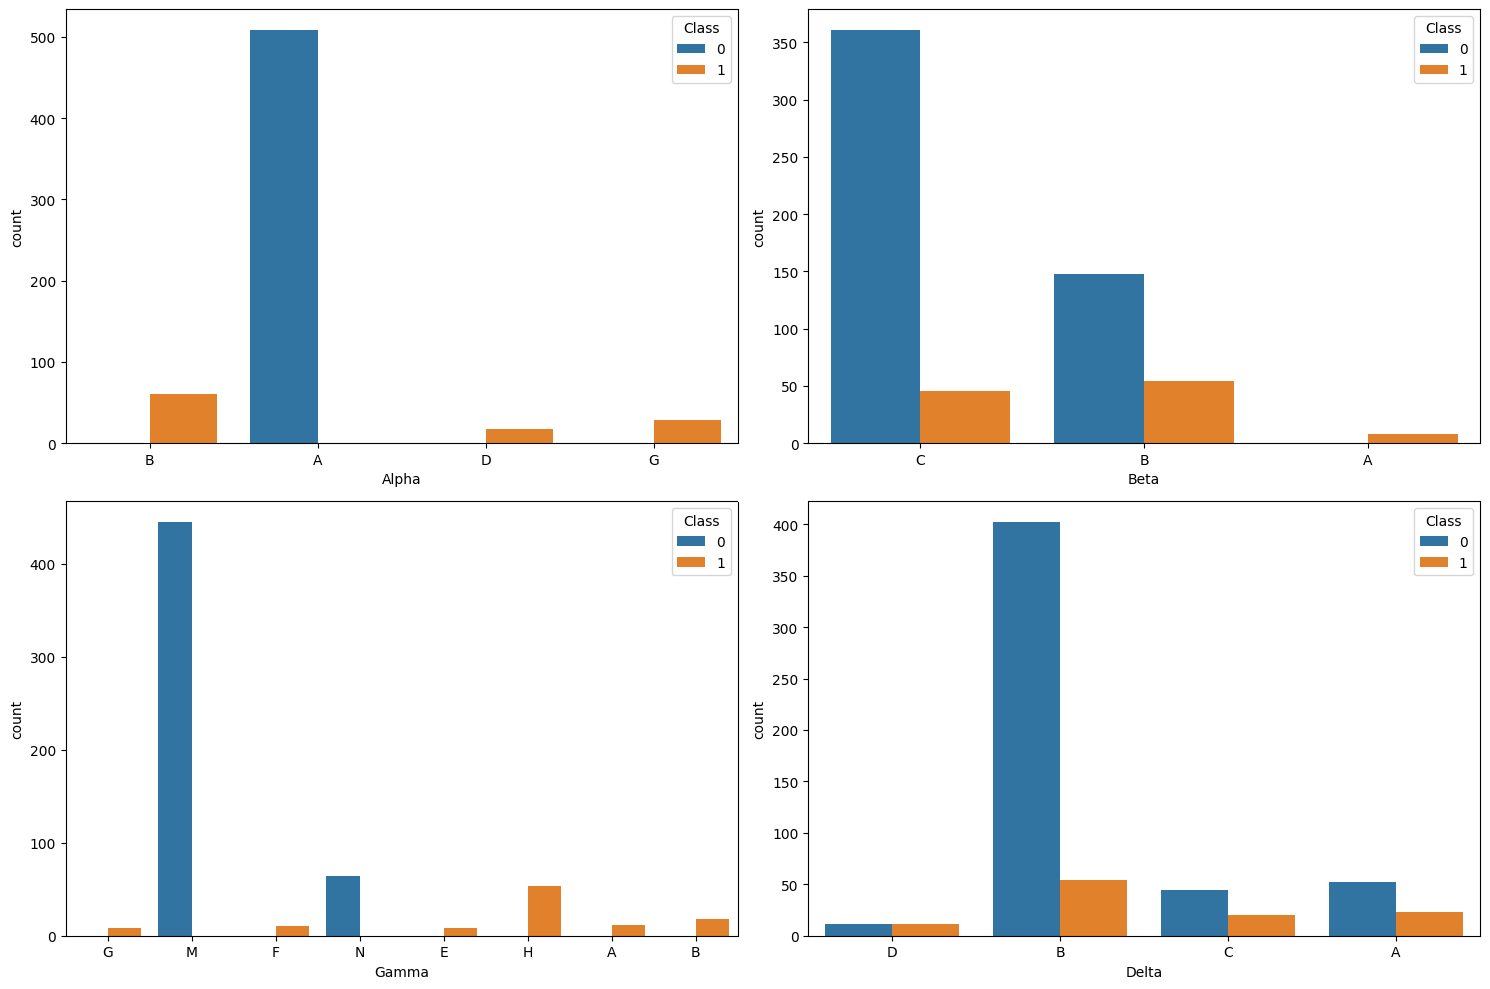

In [6]:
# カテゴリ特徴量のリストを作成
categorical_features = ['Alpha', 'Beta', 'Gamma', 'Delta']

# 各カテゴリ特徴量についてカウントプロットを描く
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for feature, ax in zip(categorical_features, axs.ravel()): # ravel: 2次元配列を１次元配列にする
    sns.countplot(x=feature, hue='Class', data=merged_data, ax=ax)

plt.tight_layout() # サブプロット間の正しい間隔を自動的に維持
plt.show()

## 考察
* AlphaはClass0がAにしかないので、A->0, (B, C, D) -> 1にすべき？

## 参考Notebook - ICR (0.17) - kNN|SMOTE|XGBoost+LGBM
<https://www.kaggle.com/code/bennyfung/icr-0-17-knn-smote-xgboost-lgbm>

## 概要
1. 目的変数の分布を分析し、値1と値0の間の不均衡を評価することで、オーバーサンプリングが必要かどうかを判断する。
2. 欠損値の分析は、欠損値の存在をチェックするために行われ、これは後のプロセスで機械学習に影響を与える。
3. ヒストグラムと箱ひげ図は、歪度を視覚化し、異常値を特定するために使用され、データ標準化のための適切な方法の選択に役立つ。
4. データ処理には、外れ値の取り扱いを考慮して、数値特徴を標準化するためにロバスト・スケーラーが選択される。さらに、カテゴリー特徴の符号化にはCatBoost Encoderを利用し、欠損値の処理にはkNN Imputerを採用している。
5. クラスの不均衡に対処するために、SMOTE（Synthetic Minority Over-sampling Technique）が少数クラスをオーバーサンプリングするために採用され、データセットのバランスをとるために合成サンプルが生成される。
6. SelectKBest特徴選択法を用いて、p値の低い特徴をTarget Labelで選択する。
7. 最後に、ハイパーパラメータを調整した様々な基本分類器を適用する。
### 2 に関する補足(歪度のデータ加工への影響について)
歪度（skewness）は、データの分布が正規分布からどれだけ歪んでいるかを示す統計的指標です。　　
データが完全に正規分布している場合、歪度は0となります。正の歪度は右側に長い尾（つまり、異常に大きな値が存在する）を示し、負の歪度は左側に長い尾（つまり、異常に小さな値が存在する）を示します
歪度はデータの標準化や欠損値処理にいくつかの方法で影響を与えます：
* 標準化: 歪度が高い（つまり、データが正規分布から大きく離れている）場合、標準化（平均を0に、標準偏差を1に変換するプロセス）を直接適用すると、元のデータのパターンを正確に反映できない可能性があります。この場合、まずデータの分布を正規分布に近づけるための変換（たとえば対数変換やBox-Cox変換）が必要となる場合があります。
* 欠損値処理: データが正規分布に従っていると仮定して欠損値を補完する方法（例えば、平均や中央値での補完）がよく使われます。しかし、データの分布が大きく歪んでいる場合、この方法は必ずしも適切ではないかもしれません。その場合、より洗練された方法（例えば、多重代入法やKNNイメピュテーションなど）が必要になるかもしれません。  
したがって、歪度を理解することは、データの前処理や欠損値処理にとって非常に重要なステップと言えます。
### 3に関する補足
* ロバスト・スケーラーについて  
ロバスト・スケーラー（Robust Scaler）は、データを標準化する手法の一つで、データの中央値を0、IQR（四分位範囲）を1にスケーリングします。これは、データに外れ値が含まれている場合や、データの分布が正規分布に従わない場合に特に有用です。ロバスト・スケーラーは、外れ値の影響を受けにくい中央値とIQRを使用するため、「ロバスト」（頑健）と呼ばれます。

* CatBoost Encoderについて  
CatBoost Encoderは、カテゴリ変数を処理するためのエンコーディング手法の一つです。CatBoost Encoderは、ターゲットエンコーディングの一種で、特に順序などの情報がないカテゴリ変数を扱う際に有効です。ターゲットエンコーディングとは、カテゴリ変数の各レベルを、そのレベルのターゲット変数の平均値で置き換える手法のことを指します。CatBoost Encoderは、ターゲットエンコーディングと同様に、カテゴリ変数をターゲット変数の情報に基づいて変換しますが、過学習を避けるために、特定の順序でデータを見ていき、過去のデータのみに基づいてエンコーディングを行います。

* KNN Imputerについて  
KNN Imputerは、データの欠損値を補完するための手法の一つで、K-Nearest Neighbors（K最近傍法）アルゴリズムに基づいています。欠損値を持つインスタンスに対して、そのインスタンスに最も近いk個のインスタンス（「最近傍」）を見つけ、これらの最近傍インスタンスの値の平均（または中央値など）を用いて欠損値を補完します。KNN Imputerは、単純な平均値や中央値による補完よりも、データの構造をよりよく保持することができます。ただし、計算量が大きいため、大規模なデータセットに対しては計算時間が長くなる可能性があります。
### 4に関する補足(SMOTEについて)
* オーバーサンプリング（Oversampling）は、不均衡なクラス分布を持つデータセットに対する問題を緩和するための一般的な手法の一つです。不均衡なデータセットとは、一部のクラスのデータが他のクラスよりも大幅に多い、または少ないデータセットを指します。このような状況では、機械学習モデルは多数派のクラスに偏って学習する傾向があります。
* オーバーサンプリングでは、少数派クラスのデータを増やす（つまり「サンプリング」する）ことで、この問題を解決します。これにより、データセット内のクラスの不均衡が緩和され、モデルが全体的にバランスの良い予測を行うことが可能になります。
* 具体的には、ランダムなオーバーサンプリングでは、既存の少数派クラスのインスタンスからランダムに選択し、それらのコピーをデータセットに追加します。一方、より洗練されたテクニックであるSMOTE（Synthetic Minority Over-sampling Technique）などの合成的なオーバーサンプリング手法では、少数クラスの新しいサンプルを「合成」することで、クラス間の不均衡を緩和します。
* SMOTEでは、以下の手順で新しいサンプルを生成します：
1. 少数クラスのサンプルをランダムに選びます。
1. 選んだサンプルから最も近いk個のサンプル（通常はk=5）を見つけます。
1. これらのk個の近傍サンプルの中からランダムに1つを選びます。
1. 選んだサンプルとその近傍サンプルとの間に新しいサンプルをランダムに生成します。  
これにより、元の少数クラスの特性を維持しつつ、そのクラスの新しいサンプルを生成することができます。これにより、クラス間の不均衡を緩和し、モデルが少数クラスをより正確に予測するのを助けます。ただし、合成サンプリングは適用する際には注意が必要で、過剰なサンプリングはモデルの過学習を引き起こす可能性があるからです。

### 1. 目的変数の分布を確認

In [7]:
train['Class'].value_counts().rename('Class').reset_index(name='Counts')

,Class,Counts
0,0,509
1,1,108


Text(0.5, 1.0, 'Distribution of Target Label (i.e. Class)')

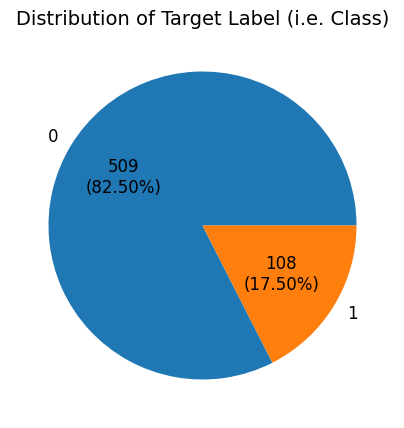

In [8]:
plt.figure(figsize=(5, 5))

# パーセント表記を行うための関数
def auto_fmt(pct_value):
    return '{:.0f}\n({:.2f}%)'.format(train['Class'].value_counts().sum()*pct_value/100, pct_value)

# クラスの各値(Class)と個数(Counts)を特徴量に持つデータフレームを生成
df_transported_count = train['Class'].value_counts().rename('Class').reset_index(name='Counts')

fig = plt.gcf() # 現在のfigureを取得
plt.pie(x=df_transported_count['Counts'], labels=df_transported_count['Class'], autopct=auto_fmt, textprops={'fontsize': 12})
plt.title('Distribution of Target Label (i.e. Class)', fontsize=14)

### 考察
目的変数の分布は不均一なため、例えばSMOTE（Synthetic Minority Over-sampling Technique）のようなオーバーサンプリングが必要かもしれない。

## 2. 欠損値の分析

In [9]:
# 訓練データから数値データのみ抽出
df_train_numerical = train.drop(['Id', 'EJ', 'Class'], axis=1)

<Figure size 1000x600 with 0 Axes>

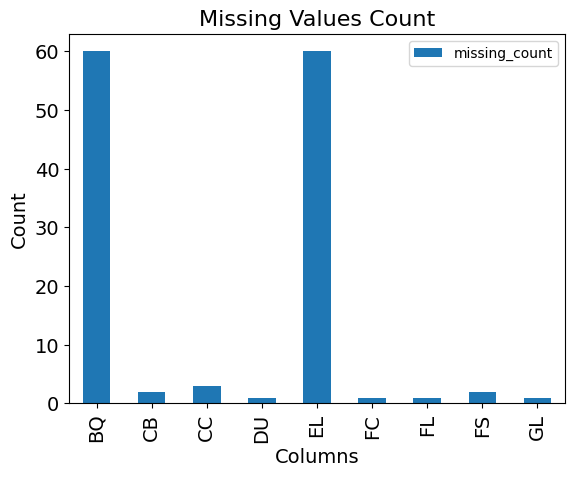

In [10]:
plt.figure(figsize=(10, 6))
# 欠損値の数を変数に代入
df_train_missing = df_train_numerical.isnull().sum().reset_index()
# 列名を変更
df_train_missing.columns = ['feature', 'missing_count']
# 欠損値がある列だけ抽出
df_train_missing = df_train_missing.loc[df_train_missing['missing_count']>0]
# 棒グラフを生成
df_train_missing.plot.bar(x='feature', y='missing_count')

# タイトル、軸名を設定
plt.title('Missing Values Count', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Count', fontsize=14)
# メモリのラベルのフォントサイズを変更
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

plt.show()

In [11]:
greeks[greeks.Epsilon=='Unknown'].shape[0]/greeks.shape[0]

0.233387358184765

## 3. 記述統計

In [12]:
# 数値データの記述統計を確認（特徴量が多いから転置）
df_train_numerical.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


## 4. ヒストグラム
ヒストグラムに表示される分布の形状を調べ、データの歪度を判定する。

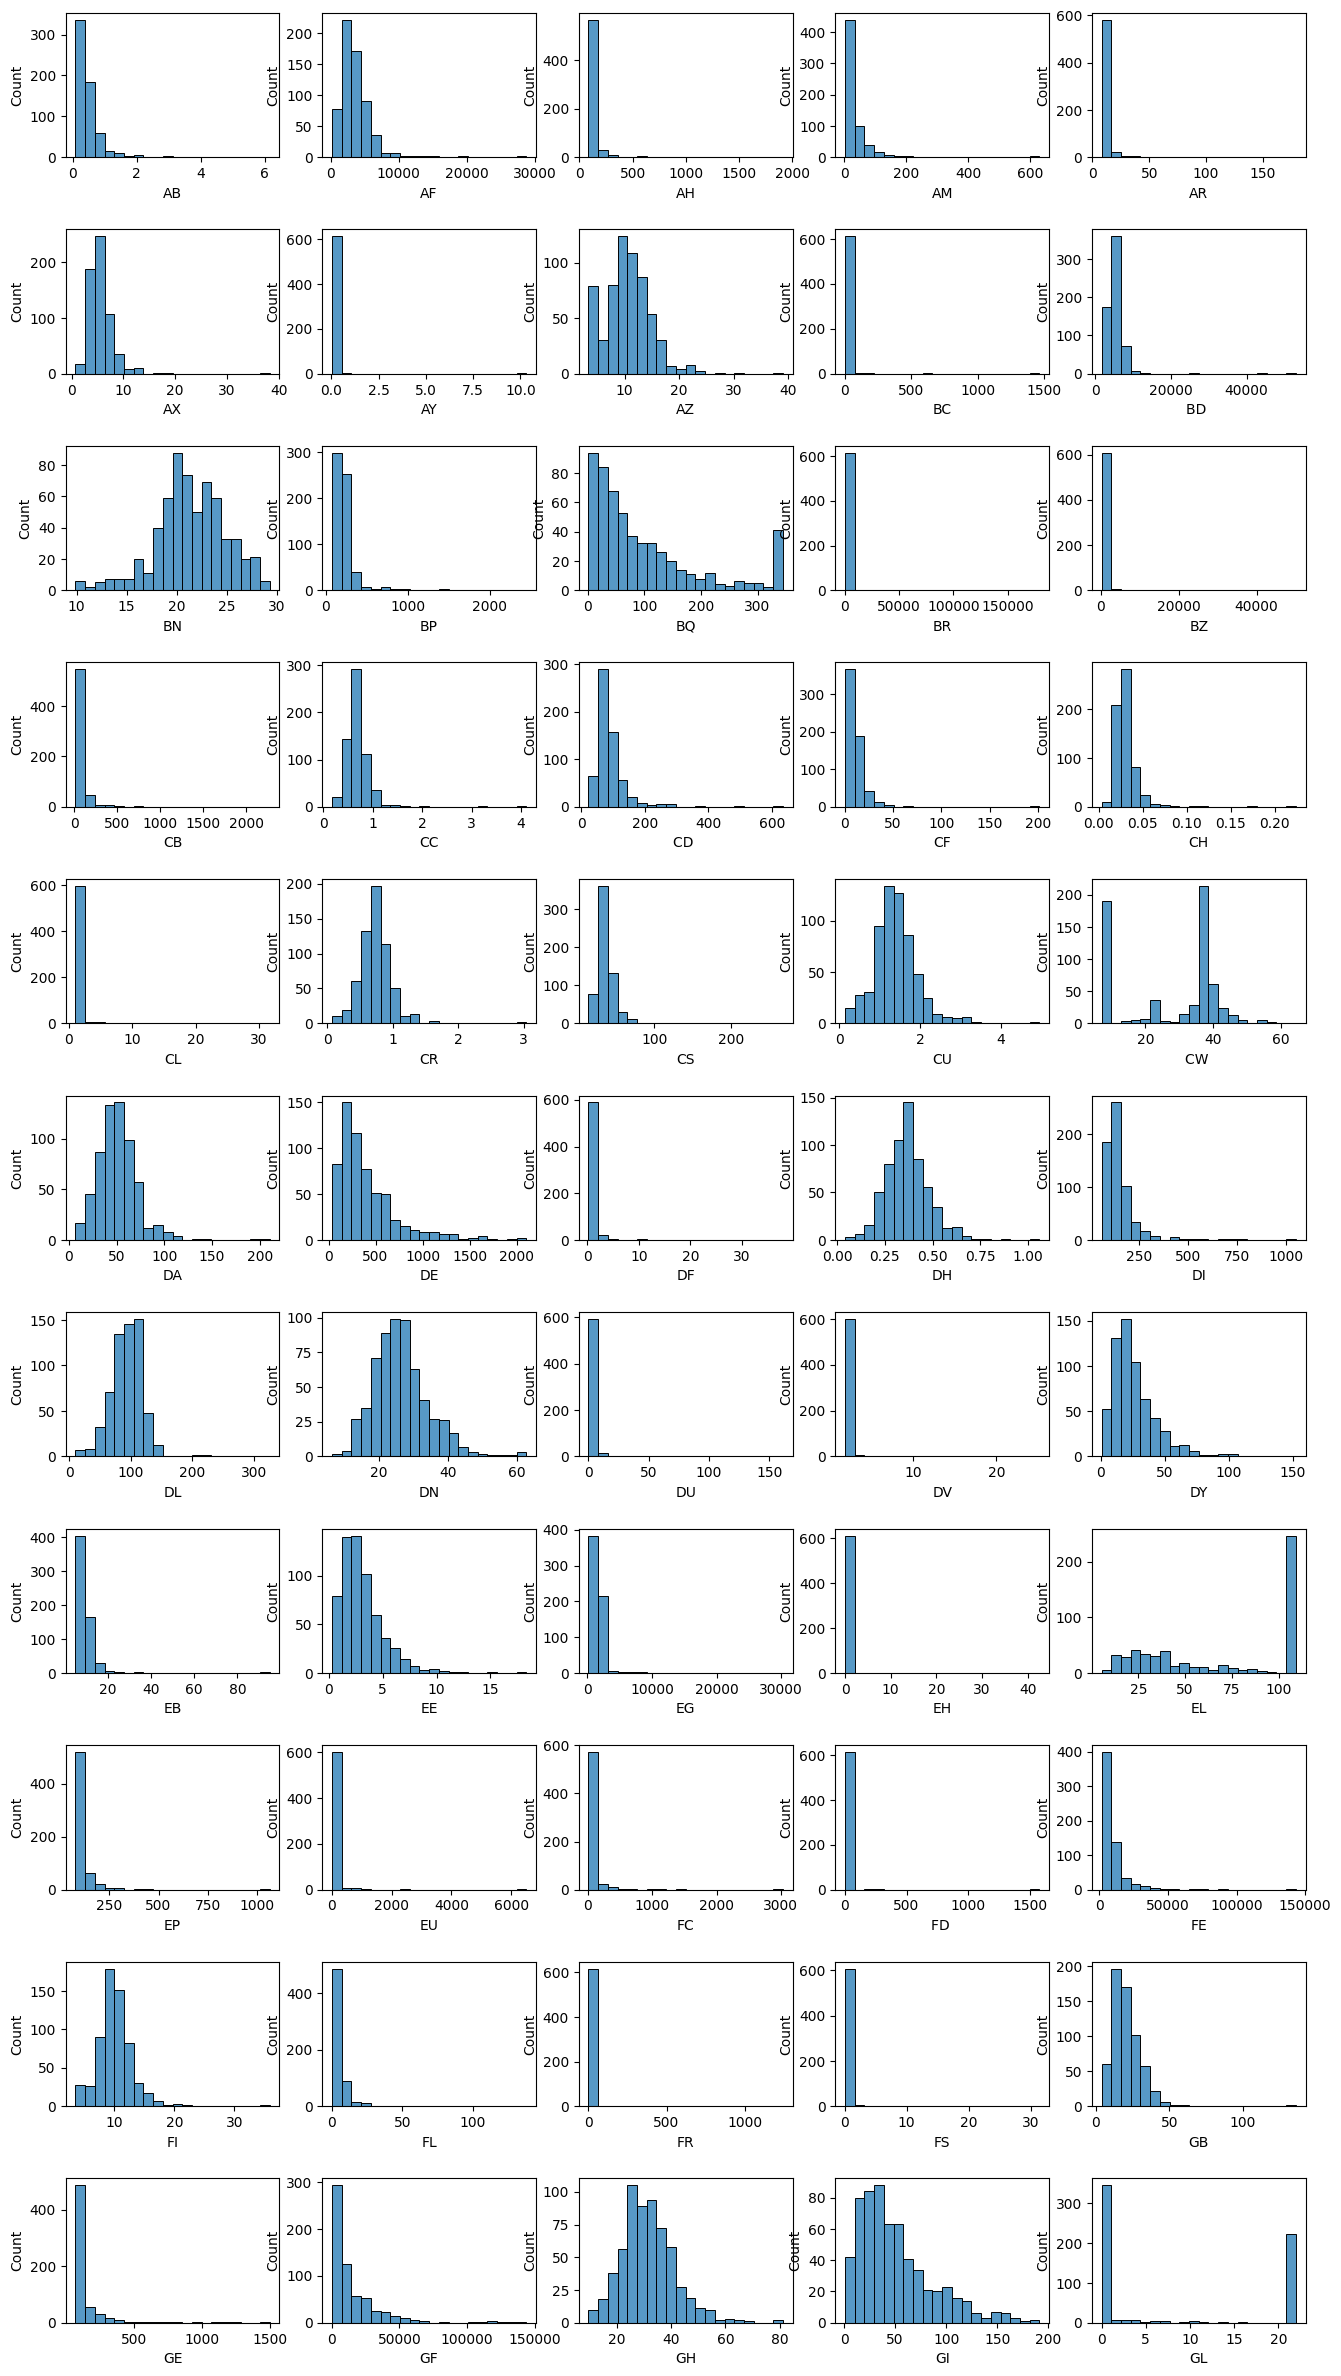

In [13]:
# 数値データのヒストグラムを格納
fig, ax = plt.subplots(11, 5, figsize=(16, 30))

# 各特徴量ごとにヒストグラムを生成
for i in range(0, len(ax.flatten())):
    sns.histplot(data=df_train_numerical, x=df_train_numerical.iloc[:, i], bins=20, ax=ax[int(i/5), i % 5])

# subplot間の垂直方向の間隔を調整する
plt.subplots_adjust(hspace=0.5)

plt.show()

## 5. 箱ひげ図
データの外れ値を識別

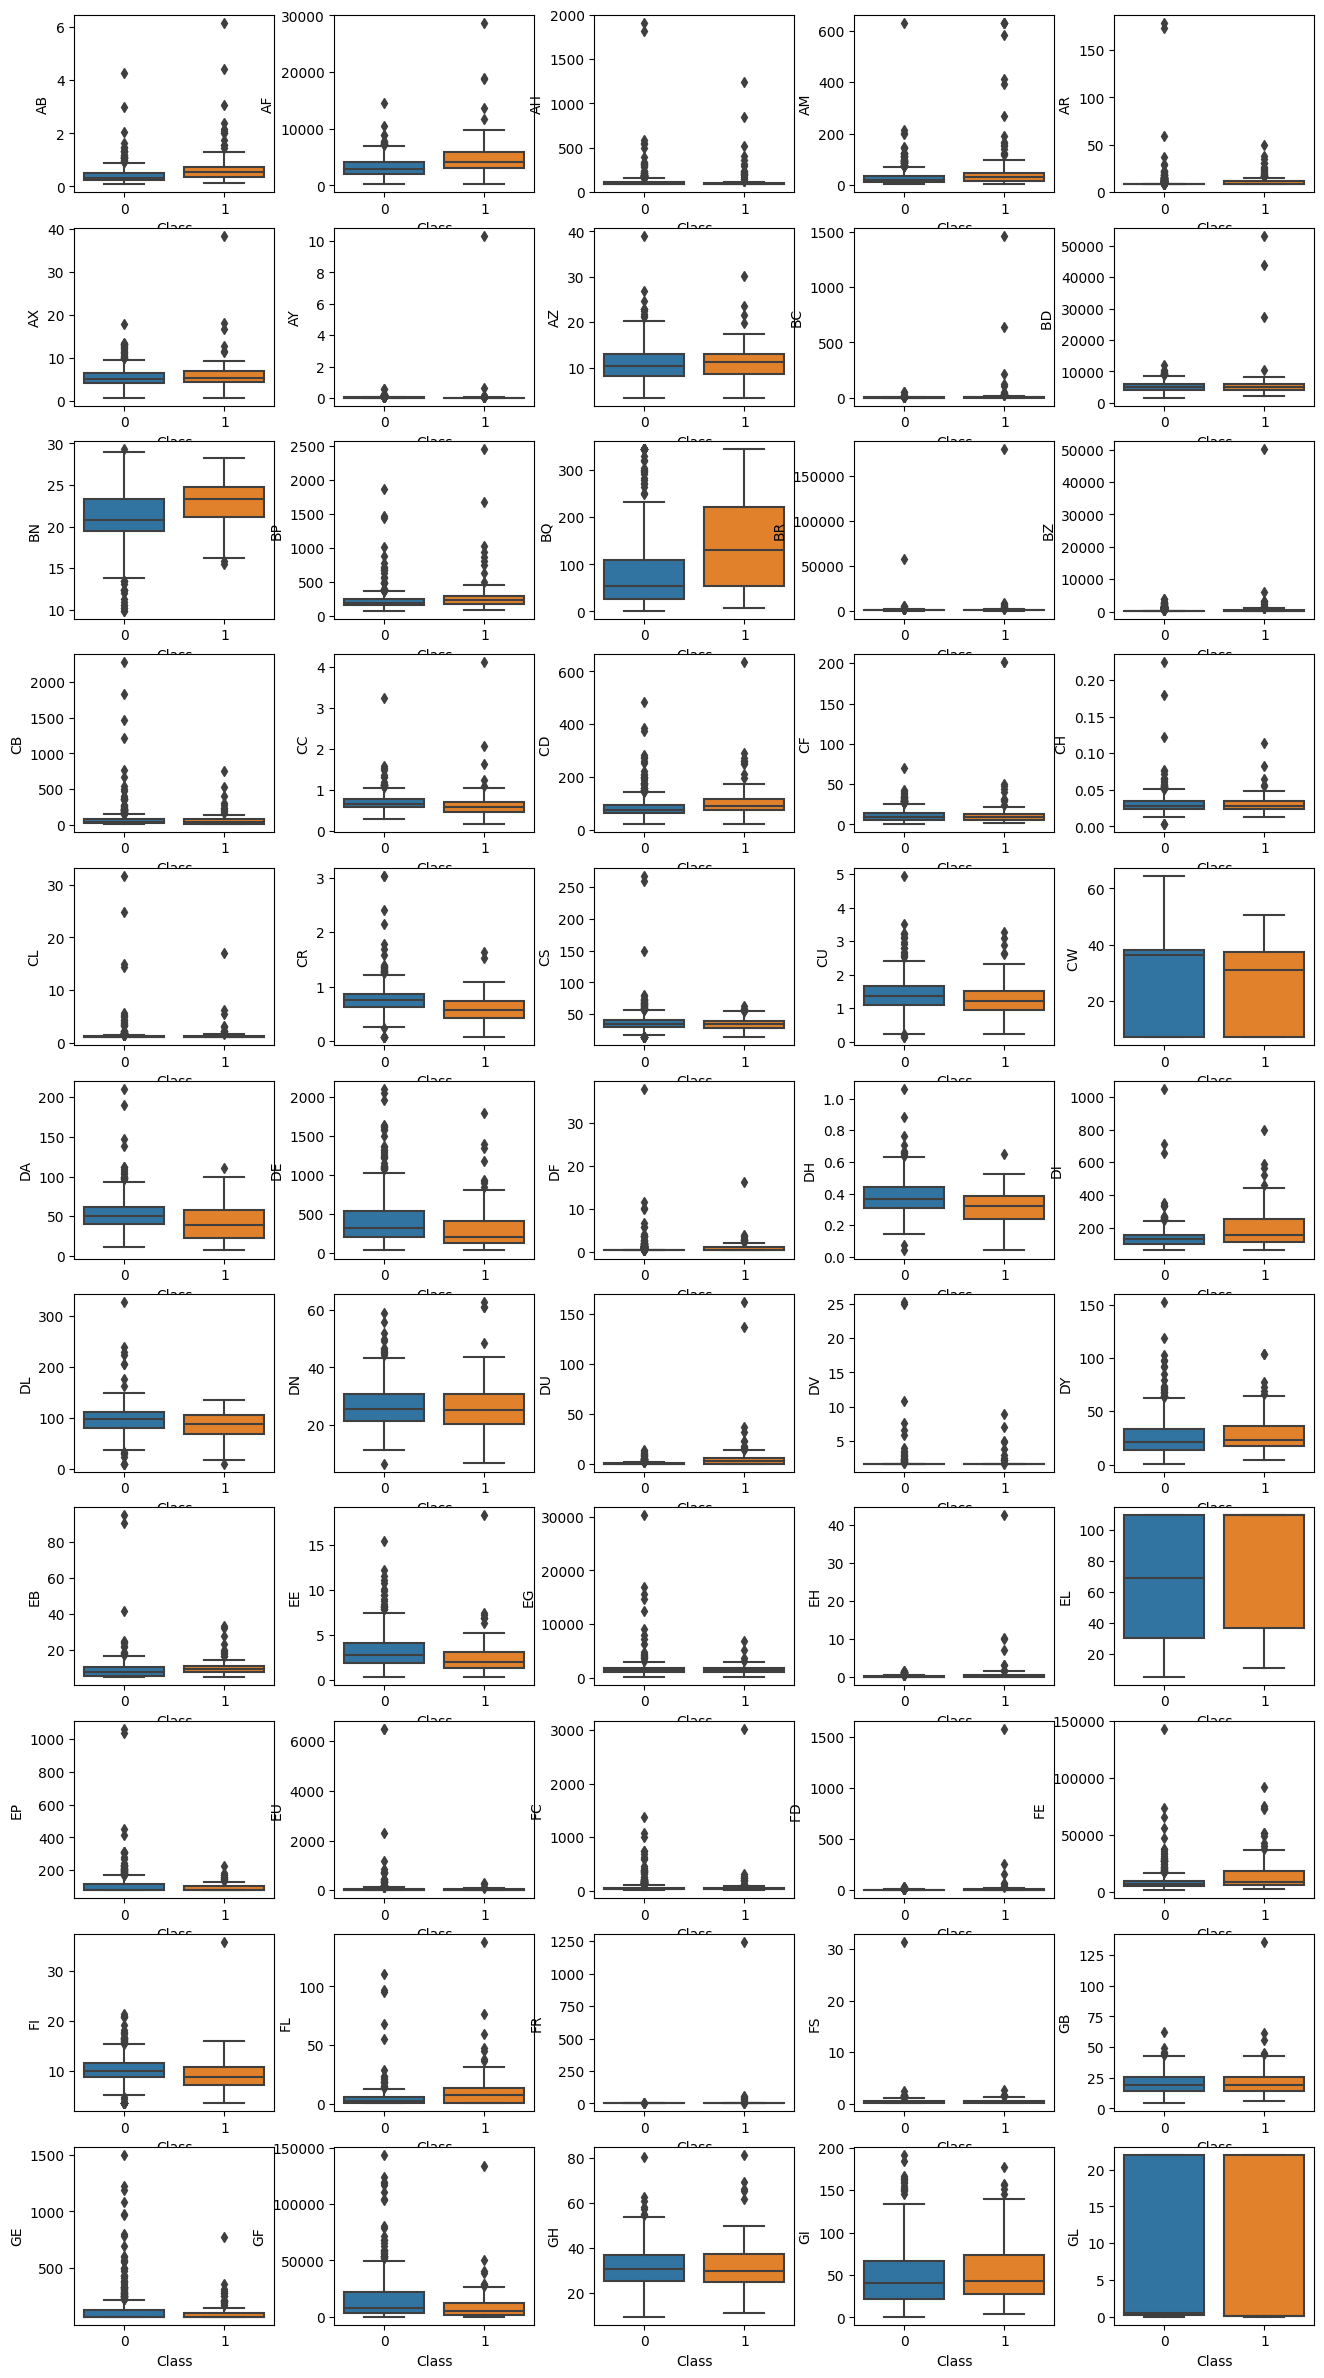

In [14]:
fig, ax = plt.subplots(11, 5, figsize=(16, 30))

# 各特徴量ごとに箱ひげ図を生成
for i in range(0, len(ax.flatten())):
    sns.boxplot(x='Class', y=df_train_numerical.columns[i], data=train, ax=ax[int(i/5), i % 5])

# subplot間の水平方向の幅を設定
plt.subplots_adjust(wspace=0.3)

plt.show()

### 考察
* 記述的分析およびヒストグラム分析に基づくと、数値特徴量が異なる分散および分布を示していることが明らか。一貫性と比較可能性を確保するためには、モデリングプロセスを進める前に、スケールを変更することで特徴量を標準化することが極めて重要である。

* さらに、箱ひげ図分析により、いくつかの数値特徴に外れ値が存在することが明らかになった。歪度と外れ値に効果的に対処するために、数値特徴の標準化にロバスト・スケーラーを利用する。

* ロバスト・スケーラは、スケーリング処理中に外れ値を自動的に処理できるため、このタスクに適しており、極端な値に対するロバスト性を提供する。ロバスト・スケーラーを採用することで、外れ値の影響を軽減し、より信頼性の高い正確なモデリング結果を得ることができる。

## 6. カテゴリカルデータの棒グラフ
カテゴリカルデータのクラスの度数を調べる

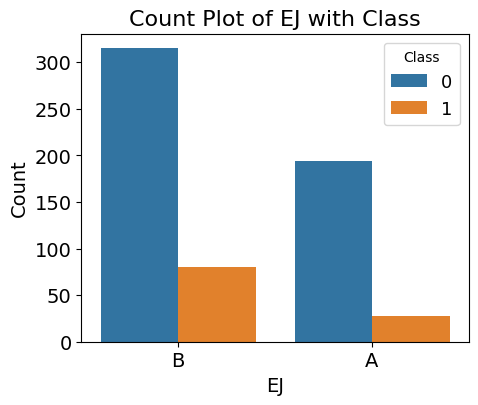

In [15]:
plt.figure(figsize=(5, 4))

# 棒グラフを生成
sns.countplot(data=train, x='EJ', hue='Class')

# タイトルと軸名を設定
plt.xlabel('EJ', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count Plot of EJ with Class', fontsize=16)

# メモリのラベルのフォントサイズを変更
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

# 凡例
plt.legend(title='Class', fontsize=13)

plt.show()

## 7. EJについて
EJがAの時EHは一定になるためEHの情報さえあればいい->EJは削除してもいいかも？

In [16]:
# EJがAの時のEHがとる値を出力
train[train['EJ']=='A']['EH'].value_counts()

EH
0.003042    222
Name: count, dtype: int64

## 8. 相関係数

In [17]:
def identify_high_correlation_pairs(corr_matrix, threshold=0.8):
    # 相関行列をフラットにし、相関の強いペアを見つける
    # （相関係数が1のものは自分自身との相関なので除外）
    strong_pairs = [(i, j) for i in range(corr_matrix.shape[0]) for j in range(i+1, corr_matrix.shape[0]) if abs(corr_matrix.iloc[i, j]) > threshold]

    # 相関の強いペアの名前を取得
    strong_pairs_names = [(corr_matrix.columns[i], corr_matrix.columns[j]) for i, j in strong_pairs]

    return strong_pairs_names

In [18]:
# 相関係数が0.8以上の特徴量の組を特定
corr_matrix = df_train_numerical.corr()
identify_high_correlation_pairs(corr_matrix, threshold=0.8)

[('AR', 'DV'),
 ('BC', 'BZ'),
 ('CL', 'DV'),
 ('DU', 'EH'),
 ('DU', 'FD '),
 ('EH', 'FD ')]

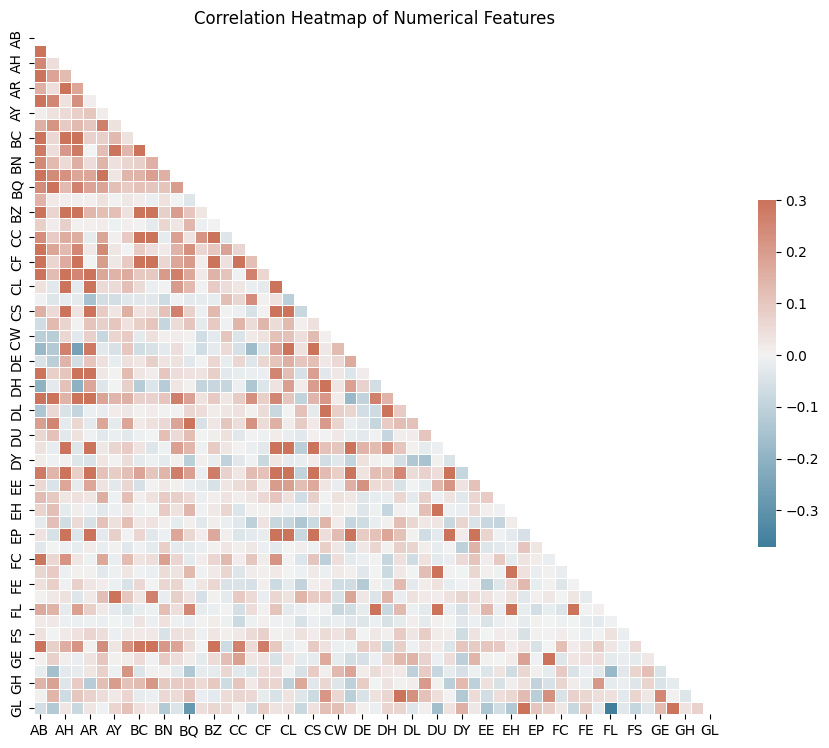

In [19]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## 9. feature importance（light gbm）

In [20]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')

In [21]:
# hyerparameter.ipynbで算出したlight-gmbのパラメータ
best_param = {'lambda_l1': 3.9679492838164295e-07, 'lambda_l2': 6.757138144718837e-07, 'num_leaves': 7, 'feature_fraction': 0.6627683984494798, 'bagging_fraction': 0.9135956967880636, 'min_child_samples': 32}

# 設定値
class CFG:
    # 変更するパラメータ
    n_folds = 20 # 公差検証の分割数(多くて20)
    n_trials = 20 # ハイパーパラメータチューニングの試行回数(100)
    device_type = "cpu"
    # device_type = "cuda"
    boosting_type = "dart"
    
    
    # その他設定値
    learning_rate = 0.01
    seed = 3407 
    target_col = 'Class'
    num_boost_round = 50500
    early_stopping_round = 300
    verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される

    # light-gbm設定値
    lgb_params = {
        'verbosity': -1, # 学習途中の情報を表示するかどうか
        "lambda_l1": best_param['lambda_l1'],
        "lambda_l2": best_param['lambda_l2'],
        "num_leaves": best_param['num_leaves'],
        "feature_fraction": best_param['feature_fraction'],
        "bagging_fraction": best_param['bagging_fraction'],
        "min_child_samples": best_param['min_child_samples'],
        "boosting_type": boosting_type,
        "device_type": device_type,
        "objective": "binary",
        "learning_rate": learning_rate,
        "metric": "binary_logloss",
        'seed': seed,
        'n_jobs': -1, # -1でコア数をマックスで使う
        'is_unbalance':True, # 不均衡データの場合にTrueにする
    }
# 評価基準
def balanced_log_loss(y_true, y_pred):
    N = len(y_true)

    # Nc is the number of observations
    N_1 = np.sum(y_true == 1, axis=0)
    N_0 = np.sum(y_true == 0, axis=0)

    # In order to avoid the extremes of the log function, each predicted probability 𝑝 is replaced with max(min(𝑝,1−10−15),10−15)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)

    # balanced logarithmic loss
    loss_numerator = - (1/N_0) * np.sum((1 - y_true) * np.log(1-y_pred)) - (1/N_1) * np.sum(y_true * np.log(y_pred))

    return loss_numerator / 2

# Classの０，１の割合をそれぞれ計算
def calc_log_loss_weight(y_true):
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

def lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
    # 訓練データの重みを計算
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    # 検証データの重みを計算
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    # 訓練データをlgb用に変換
    lgb_train = lgb.Dataset(x_train, y_train, weight=y_train.map({0: train_w0, 1: train_w1}), categorical_feature=categorical_features)
    # 検証データをlgb用に変換
    lgb_valid = lgb.Dataset(x_valid, y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}), categorical_feature=categorical_features)

    model = lgb.train(
        params = CFG.lgb_params,
        train_set = lgb_train,
        num_boost_round = CFG.num_boost_round,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = CFG.early_stopping_round,
        verbose_eval = CFG.verbose_eval,
        # 学習段階でbalanced_log_lossを使う場合はコメントアウト外す
        # feval = lgb_metric,
    )
    
    # 予測
    valid_pred = model.predict(x_valid)
    return model, valid_pred

In [22]:
# EJを数値に変換
train['EJ'] = train['EJ'].replace({'A': 0, 'B': 1})
# 特徴量のリストを作成
features = [item for item in train.columns.values.tolist() if item not in ['Id', 'Class']]
# カテゴリカルデータのリストを作成
categorical_features = ['EJ']

In [23]:
# 訓練データを説明変数と目的変数に分割
X = train.drop(['Id', 'Class'], axis=1)
y = train['Class']
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# 訓練データの重みを計算
train_w0, train_w1 = calc_log_loss_weight(y_train)
# 検証データの重みを計算
valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
# 訓練データをlgb用に変換
lgb_train = lgb.Dataset(x_train, y_train, weight=y_train.map({0: train_w0, 1: train_w1}))
# lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
# 検証データをlgb用に変換
lgb_valid = lgb.Dataset(x_valid, y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}))

# 学習
model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features=features, categorical_features=categorical_features)

# feature_importancesをpd.Seriesに格納
importances = pd.Series(model.feature_importance(), index=X.columns)

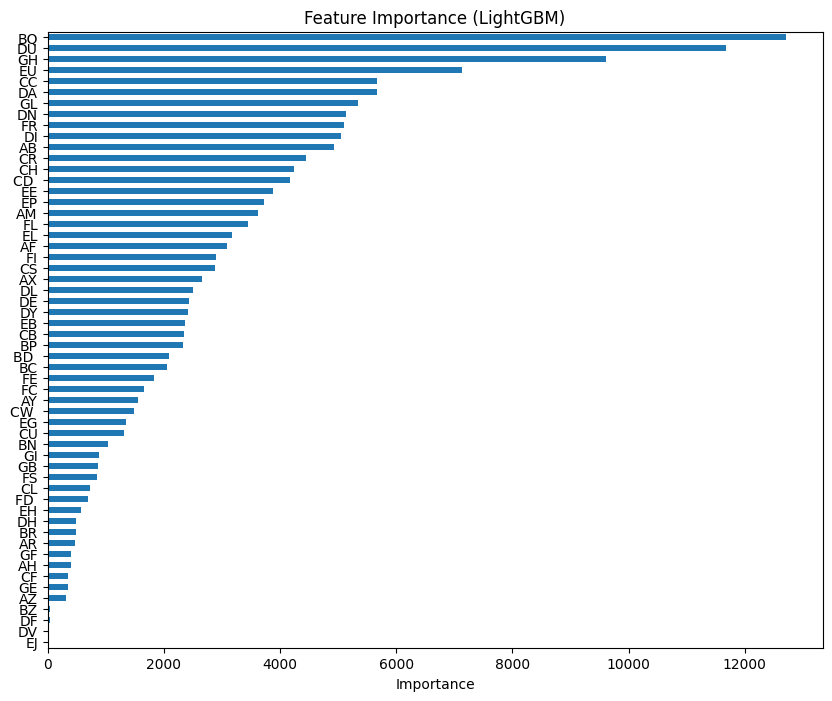

In [25]:
# feature_importanceをpd.Series化
importances_series = pd.Series(importances, index=X.columns)
# 重要度の高い順にソート
importances_sorted = importances_series.sort_values(ascending=True)

# 棒グラフを出力
plt.figure(figsize=(10,8))
importances_sorted.plot(kind='barh')
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance')
plt.show()

## 10. Classとgreeksの相関を確認

In [42]:
df_class_greeks = merged_data.iloc[:, -6:-1]
df_class_greeks

,Class,Alpha,Beta,Gamma,Delta
0,1,B,C,G,D
1,0,A,C,M,B
2,0,A,C,M,B
3,0,A,C,M,B
4,1,D,B,F,B
...,...,...,...,...,...
612,0,A,B,M,B
613,0,A,B,M,B
614,0,A,C,M,B
615,0,A,C,M,B


In [43]:
print('ユニークな値の一覧')
print('Alpha: {}'.format(df_class_greeks.Alpha.unique()))
print('Beta: {}'.format(df_class_greeks.Beta.unique()))
print('Gamma: {}'.format(df_class_greeks.Gamma.unique()))
print('Delta: {}'.format(df_class_greeks.Delta.unique()))

ユニークな値の一覧
Alpha: ['B' 'A' 'D' 'G']
Beta: ['C' 'B' 'A']
Gamma: ['G' 'M' 'F' 'N' 'E' 'H' 'A' 'B']
Delta: ['D' 'B' 'C' 'A']


In [45]:
df_class_greeks['Alpha'] = df_class_greeks['Alpha'].replace({'A': 0, 'B': 1, 'D': 1, 'G': 1})
df_class_greeks['Beta'] = pd.factorize(df_class_greeks['Beta'])[0]
df_class_greeks['Gamma'] = pd.factorize(df_class_greeks['Gamma'])[0]
df_class_greeks['Delta'] = pd.factorize(df_class_greeks['Delta'])[0]

In [46]:
df_class_greeks

,Class,Alpha,Beta,Gamma,Delta
0,1,1,0,0,0
1,0,0,0,1,1
2,0,0,0,1,1
3,0,0,0,1,1
4,1,1,1,2,1
...,...,...,...,...,...
612,0,0,1,1,1
613,0,0,1,1,1
614,0,0,0,1,1
615,0,0,0,1,1


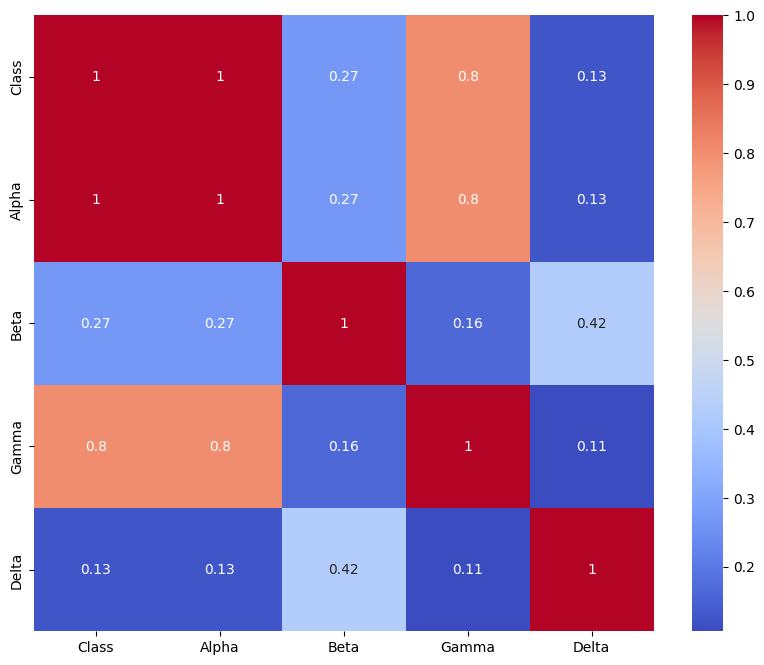

In [47]:
# 相関行列の計算
corr = df_class_greeks.corr()

# ヒートマップの描画
plt.figure(figsize=(10,8))  # サイズ調整
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.show()